In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

In [2]:
df = pd.read_csv("data/IRS-ON-CorridorJunction/IRS_ON_Sitting_Tx1.csv", header=None)

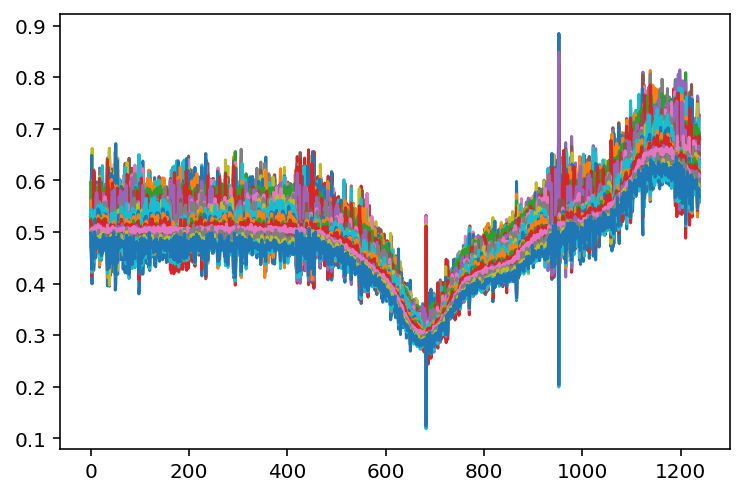

In [3]:
df.transpose().plot(legend=False);

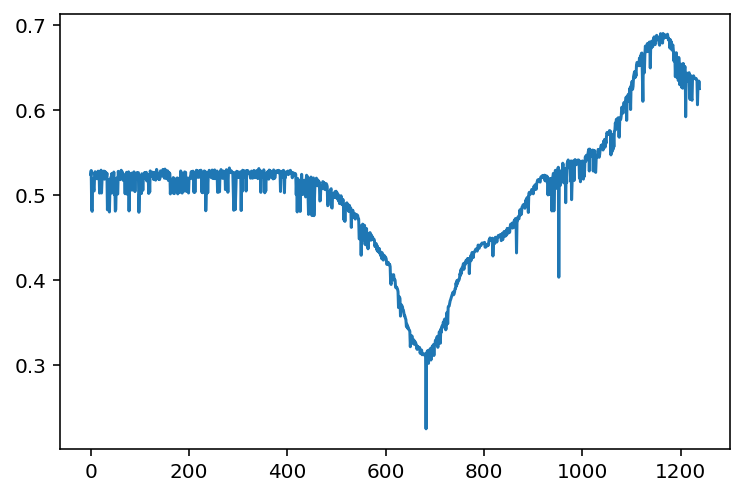

In [4]:
df.mean().plot(legend=False);

In [69]:
def files(condition, action):
    
    if condition == "IRS-OFF-CorridorJunction":
        if action == "Empty":
            fp = "IRS_OFF_Empty_Rx*.csv"
        elif action == "Sitting":
            fp = f"IRS_OF_{a}_Tx*.csv"
        else:
            fp = f"IRS_OFF_{a}_Tx*.csv"
            
    elif condition == "IRS-OFF-Multifloor":
        if action == "Empty":
            fp = "EmptyOFF_*.csv"
        else:
            fp = f"{a}_IRS-OFF_*.csv"
    
    elif condition == "IRS-ON-CorridorJunction":
        if action == "Empty":
            return None
        else:
            fp = f"IRS_ON_{a}_Tx*.csv"
                    
    elif condition == "IRS-ON-Multifloor":
        if action == "Empty":
            fp = "Empty_*.csv"
        else:
            fp = f"{a}_IRS-ON_*.csv"
    
    else:
        raise ValueError
        
    return glob.glob(f"data/{condition}/{fp}")

In [70]:
conditions = "IRS-OFF-CorridorJunction", "IRS-OFF-Multifloor", "IRS-ON-CorridorJunction", "IRS-ON-Multifloor"

In [71]:
actions = "Sitting", "Walking", "Standing"

In [72]:
COND = conditions[0]
COND

'IRS-OFF-CorridorJunction'

In [73]:
len_records = []

for a in actions:
    for f in files(COND, a):
        df_f = pd.read_csv(f, header=None) 
        len_records.append(df_f.shape[-1])

In [74]:
shortest_seq = min(len_records)
f"Shortest sequence = {shortest_seq}"

'Shortest sequence = 1245'

In [75]:
n_obs = len(len_records)
f"Number of observations = {n_obs}"

'Number of observations = 40'

In [76]:
x = np.zeros((n_obs, shortest_seq))
y = np.zeros(n_obs)

i = 0
for a in actions:
    for f in files(COND, a):
        df_f = pd.read_csv(f, header=None) 
        x[i] = df_f.mean()[:shortest_seq] 
        y[i] = actions.index(a)
        i += 1  

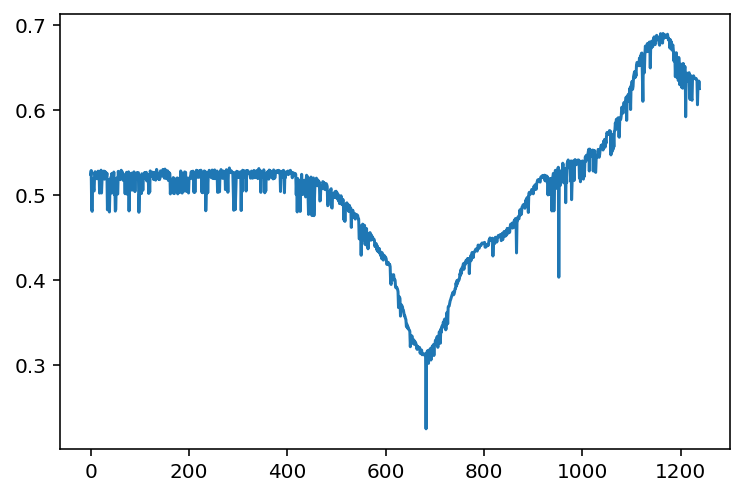

In [77]:
df.mean().plot(legend=False);

In [78]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, y):
        'Initialization'
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).long()
        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = self.x[index]
        y = self.y[index]
        return x, y

In [79]:
training_data = Dataset(x, y)

In [80]:
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=n_obs, shuffle=True)

In [81]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(min(len_records), 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(actions)),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [82]:
model = Net()

In [83]:
# initialize metric
metric = torchmetrics.Accuracy()

for i, data in enumerate(train_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data

    # Make predictions for this batch
    outputs = model(inputs)
    preds = outputs.softmax(dim=-1)

    # metric on current batch
    acc = metric(preds, labels)

acc = metric.compute()
print(f"Accuracy on all data: {acc}")


Accuracy on all data: 0.5


In [84]:
loss_fn = torch.nn.CrossEntropyLoss()

In [85]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [86]:
n_epochs = 2000
hist_loss = []
hist_acc = []

# initialize metric
metric = torchmetrics.Accuracy()

for epoch in tqdm(range(n_epochs)):   
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        hist_loss.append(loss.item())

        # Adjust learning weights
        optimizer.step()
        
        # Compute metric on current batch
        preds = outputs.softmax(dim=-1)
        acc = metric(preds, labels)
        
    acc = metric.compute()
    hist_acc.append(acc)

100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 384.20it/s]


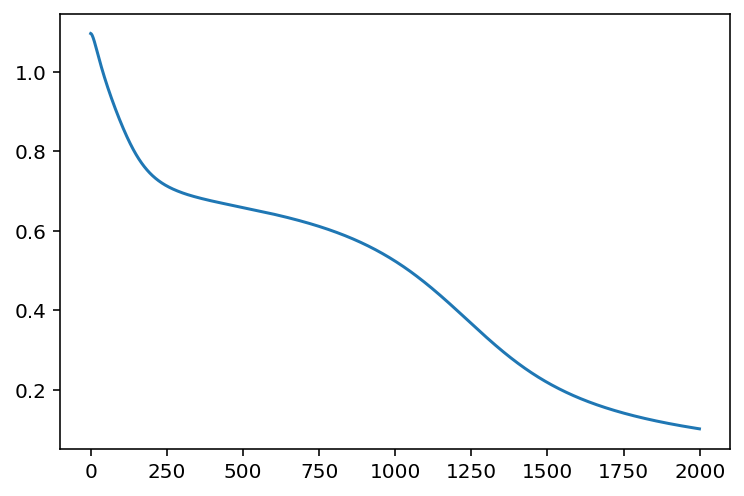

In [87]:
plt.plot(hist_loss);

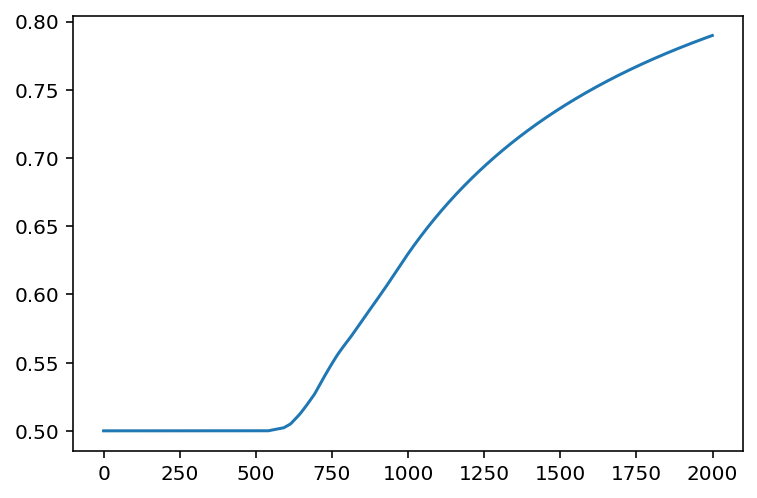

In [88]:
plt.plot(hist_acc);

In [89]:
hist_acc[-1]

tensor(0.7897)